# Create dataframes from raw data

This notebook shows how a dataframe was created for two of the datasets we used for this project (2kIMPACT and DBNL). See more info, see the [Wiki page](https://github.com/Giovanni1085/KB_OCR_impact/wiki/Datasets).

Please note this notebook is only illustrative of the procedure we have followed to prepare the datasets. Throughout the project, we have made use of the [dataframes with evaluation data](evaluation/) provided by the KB. These contain the same dataset but include an extensive [assessment of OCR quality](https://github.com/Giovanni1085/KB_OCR_impact/wiki/Evaluations).

In [2]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
import pandas as pd
from bs4 import BeautifulSoup

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

seed = 43
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2k IMPACT

In [7]:
# you will need to change this to your own location.
folder = os.path.join(os.environ['HOME'],"surfdrive/Shared/OCR")

# data folders
ocr_original_folder = "Original ALTO files " # ABBY 8
ocr_new_folder = "ReOCRed (FR11)" # ABBY 11
ground_folder = "Reordered Ground-truth"

In [8]:
def get_contents(soup):
    """
    This function reads a file and gets original filename, tokens and their confidence out of an alto xml file
    """
    filename = soup.find("filename").text
    # find all strings (== tokens) and get text plus word-level confidence
    word_level_confidence = list()
    text = list()
    for match in soup.findAll("string"):
        word_level_confidence.append(float(match["wc"]))
        text.append(match["content"])
    return filename, text, word_level_confidence

In [10]:
# limits how many files to load
# this dataset has 2000 files, so any number above it loads them all
LIMIT = 3000

#### LOAD ground truth texts

In [11]:
data_dict = {'filename':list(),'text_ground':list()}

# load xml files and get data out
for root, dirnames, filenames in os.walk(os.path.join(folder,ground_folder)):
    for f in tqdm(filenames[:LIMIT]):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"))
            filename, text, word_level_confidence = get_contents(soup)
            data_dict['filename'].append(filename)
            data_dict['text_ground'].append(text)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
# create a dataframe
df_ground = pd.DataFrame.from_dict(data_dict)
df_ground = df_ground.set_index('filename')

In [13]:
df_ground.head()

,text_ground
filename,
DDD_010197037_001.jp2,"[No., 9922., Tweede, Blad., Vrijdag, 29, Juli,..."
DDD_011219339_001.jp2,"[De, Surinamer, Redactie, J., WILLEBRANDS, Dag..."
DDD_011179281_001.jp2,"[DE, GRONDWET., Mrs., L., Mulder,, Uitgeefster..."
DDD_010948945_001.jp2,"[Het, Vrije, Volk, Maandag, 25, augustus, 1986..."
MMGARO01_000177181_002_master.jp2,"[De, troepen, vertrokken, 8, en, 9, Sept,, uit..."


#### LOAD OCR texts

In [14]:
data_dict_ocr_1 = {'filename':list(),'text_ocr':list(),'word_level_confidence_ocr':list()}
data_dict_ocr_2 = {'filename':list(),'text_reocr':list(),'word_level_confidence_reocr':list()}

# load xml files and get data out
for root, dirnames, filenames in os.walk(os.path.join(folder,ocr_original_folder)):
    for f in tqdm(filenames[:LIMIT]):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"))
            filename, text, word_level_confidence = get_contents(soup)
            data_dict_ocr_1['filename'].append(filename)
            data_dict_ocr_1['word_level_confidence_ocr'].append(word_level_confidence)
            data_dict_ocr_1['text_ocr'].append(text)
for root, dirnames, filenames in os.walk(os.path.join(folder,ocr_new_folder)):
    for f in tqdm(filenames[:LIMIT]):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"))
            filename, text, word_level_confidence = get_contents(soup)
            data_dict_ocr_2['filename'].append(filename)
            data_dict_ocr_2['word_level_confidence_reocr'].append(word_level_confidence)
            data_dict_ocr_2['text_reocr'].append(text)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

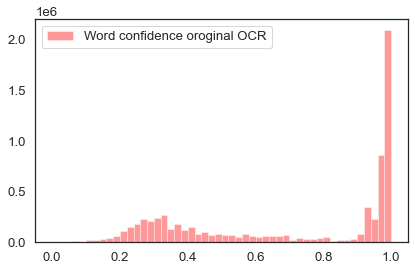

In [15]:
flatten = lambda l: [item for sublist in l for item in sublist]
l = flatten(data_dict_ocr_1['word_level_confidence_ocr'])
sns.distplot(l, label="Word confidence oroginal OCR", kde=False, color="red")
plt.legend()
plt.tight_layout()
plt.savefig("figures/2kIMPACT_word_confidence_orOCR.pdf")

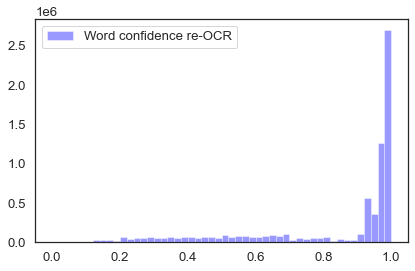

In [16]:
l2 = flatten(data_dict_ocr_2['word_level_confidence_reocr'])
sns.distplot(l2, label="Word confidence re-OCR", kde=False, color="blue")
plt.legend()
plt.tight_layout()
plt.savefig("figures/2kIMPACT_word_confidence_reOCR.pdf")

In [17]:
# create dataframes
df_ocr = pd.DataFrame.from_dict(data_dict_ocr_1)
df_ocr = df_ocr.set_index('filename')
df_reocr = pd.DataFrame.from_dict(data_dict_ocr_2)
df_reocr = df_reocr.set_index('filename')

In [18]:
df_ocr.head()

,text_ocr,word_level_confidence_ocr
filename,,
DDD_010033326_001.jp2,"[NIEUWE, ROTTERDAMSCHE, COURANT., », «.<.»«««,...","[0.98, 0.96, 0.98, 0.98, 0.96, 0.98, 0.96, 1.0..."
DDD_010541077_002.jp2,"[Kolom, Links, mensen, ♦, De, acteur, Edward, ...","[0.96, 0.96, 0.99, 0.2, 0.39, 0.99, 0.91, 0.97..."
MMDA03_000114653_002_master.jp2,"[SPORTNIEUWS, Drentsche, Voetbalbond., OFFICIE...","[0.3, 0.24, 0.31, 0.32, 0.34, 0.33, 0.38, 0.22..."
MMKB08_000166020_002_master.jp2,"[Verder, behandelt, de, Resolutie, technisch,,...","[0.4, 0.22, 0.26, 0.29, 0.3, 0.23, 0.24, 0.36,..."
DDD_010219949_001.jp2,"[Dit, nummer, bestaat, uit, vier, bladen, Eers...","[0.96, 1.0, 0.98, 0.97, 0.97, 0.96, 0.99, 0.26..."


In [19]:
df_reocr.head()

,text_reocr,word_level_confidence_reocr
filename,,
DDD_011218694_001.jp2,"[11, i, —in, >i, i, I—••, -, J, --, ■, ■, ■, D...","[0.9, 0.32, 0.9, 0.62, 0.24, 0.33, 0.37, 0.24,..."
MMSAB03_000062844_001_master.jp2,"[j\o,, 262., ,., DONDERDAG, 8, NOVEMBER, 1925....","[0.42, 0.68, 0.81, 0.97, 0.44, 0.97, 0.24, 0.1..."
MMGAVL01_000007154_001_master.jp2,"[nieuwe, lleniosche, courant, van, Zaterdag.29...","[0.97, 0.55, 0.98, 0.97, 0.99, 0.4, 0.59, 0.97..."
DDD_010189794_002.jp2,"[blikevnen, die, een, soort, van, voogdij, «Ve...","[0.3, 0.93, 0.91, 0.96, 0.92, 0.96, 0.94, 0.92..."
DDD_010882847_002.jp2,"[die, terugkomst, van, de, bewoners, overvalle...","[0.96, 0.98, 0.93, 0.33, 0.98, 0.99, 0.93, 0.9..."


In [20]:
# join data frames
full_df = pd.concat([df_ground, df_ocr], join="inner", axis=1)
full_df = pd.concat([full_df, df_reocr], join="inner", axis=1)

In [21]:
full_df.shape

(2000, 5)

In [22]:
full_df.head()

,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr
filename,,,,,
DDD_010197037_001.jp2,"[No., 9922., Tweede, Blad., Vrijdag, 29, Juli,...","[JSo., 9822, xTweede, Blad., Vrijdag, 29, Juli...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","[ISO., 9922, -Tweede, Blad., ss*, Vrijdag, 29,...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9..."
DDD_011219339_001.jp2,"[De, Surinamer, Redactie, J., WILLEBRANDS, Dag...","[De, Surinamer, •v*, WILLEBRANDS:i^, Dagblad, ...","[0.96, 0.98, 0.46, 0.48, 0.99, 0.97, 0.99, 0.5...","[Whd^Mmumr, Redactie, J., WILLEBRANDS, Dagblad...","[0.25, 0.99, 0.83, 0.84, 0.98, 0.97, 0.99, 0.9..."
DDD_011179281_001.jp2,"[DE, GRONDWET., Mrs., L., Mulder,, Uitgeefster...","[DE, GRONDWET., Mrs., 3L.., Mulder,, TJitgêels...","[0.96, 0.98, 0.95, 0.52, 0.97, 0.41, 0.34, 0.9...","[DE, GRONDWET., Mrs., Xj., Melder,, Uitgeefste...","[0.76, 0.97, 0.5, 0.62, 0.97, 0.98, 0.97, 0.74..."
DDD_010948945_001.jp2,"[Het, Vrije, Volk, Maandag, 25, augustus, 1986...","[Het, Vrije, Volk, Maandag, 25, augustus, 1986...","[0.98, 0.98, 0.98, 1.0, 1.0, 0.98, 0.86, 0.63,...","[Ê, •, :>, %, V, f, A, i, *, %, iiiisy, V, -;,...","[0.27, 0.44, 0.14, 1.0, 0.13, 0.33, 1.0, 0.3, ..."
MMGARO01_000177181_002_master.jp2,"[De, troepen, vertrokken, 8, en, 9, Sept,, uit...","[De, tioepen, vertrokken, 8, en, 9, Sept., uit...","[0.59, 0.32, 0.32, 0.78, 0.07, 1.0, 0.25, 0.18...","[De, troepen, vertrokken, 8, en, 9, Sept., uit...","[0.5, 0.98, 0.99, 0.41, 0.46, 0.76, 0.61, 0.96..."


In [23]:
full_df["word_level_average_confidence_ocr"] = full_df["word_level_confidence_ocr"].apply(lambda x: np.average(x))
full_df["word_level_average_confidence_reocr"] = full_df["word_level_confidence_reocr"].apply(lambda x: np.average(x))

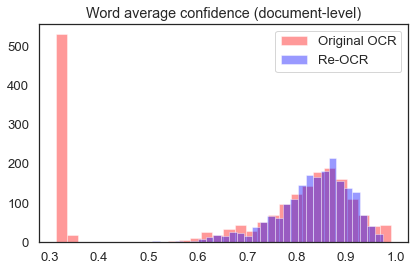

In [24]:
# compare original and re-OCR
sns.distplot(full_df["word_level_average_confidence_ocr"].values, label="Original OCR", kde=False, color="red", bins=30)
sns.distplot(full_df["word_level_average_confidence_reocr"].values, label="Re-OCR", kde=False, color="blue", bins=30)
plt.title("Word average confidence (document-level)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/2kIMPACT_word_confidence.pdf")

In [25]:
# save
full_df.to_csv("data_frames/full_df_2kIMPACT.csv", compression="gzip")

## DBNL OCR

In [26]:
# you will need to change this to your own location.
folder = os.path.join(os.environ['HOME'],"surfdrive/projects/KB_residence_OCR_2020/data/DBNL_OCR_dataset")

# data folders
ocr_folder = "TXT"
ground_folder = "TEI"
metadata_file = "Metadata_DBNL_OCR_v1.csv"

In [27]:
# load ground data by filtering for Dutch only

import requests

data_dict = {'filename':list(),'text_ground':list(),'genre':list(),'subgenre':list()}
# we use the DBNL API to get genre and subgenre, we will use this for the classification task
baseline_url = "https://dbnl.org/extern/api/titel/read_one.php"

# load xml files and get data out
for root, dirnames, filenames in os.walk(os.path.join(folder,ground_folder)):
    for f in tqdm(filenames):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"), 'html.parser') # GET the correct encoding!
            filename = f.replace("_01.xml","")
            tei_lang = soup.find("language")
            if tei_lang: # many books do not have language information, in that case we assume it's Dutch
                if not tei_lang.text == "Nederlands":
                    continue
            text = soup.find("body").text
            # find genre and subgenre
            response = requests.get(
                baseline_url,
                params={'ti_id': filename})
            response = response.json()
            genre = None
            if "genre" in response.keys():
                genre = ",".join([x[1] for x in response["genre"]])
            subgenre = None
            if "subgenre" in response.keys():
                subgenre = ",".join([x[1] for x in response["subgenre"]])
            data_dict['filename'].append(filename)
            data_dict['text_ground'].append(text)
            data_dict['genre'].append(genre)
            data_dict['subgenre'].append(subgenre)

  0%|          | 0/220 [00:00<?, ?it/s]

In [28]:
df_ground = pd.DataFrame.from_dict(data_dict)
df_ground = df_ground.set_index('filename')

In [29]:
df_ground.head()

,text_ground,genre,subgenre
filename,,,
_vad003182501,\n\n\n\n\n\nBoekbeschouwing.\nDe gemoedsgestel...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek
_vad003182401,\n\n\n\n\n\nBoekbeschouwing.\nMijne Gronden vo...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek
crem001roma12,\n\n\nROMANTISCHE WERKEN\n\nGedrukt bij Gebr. ...,proza,"roman,verzameld werk"
_taa001taal01,\n\n\n\n\nVoorbericht.\nIndien de waarde eener...,sec - taalkunde,tijdschrift / jaarboek
_vad003179201,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek


In [30]:
df_ground["genre"].value_counts()

sec - letterkunde,non-fictie         77
poëzie                               46
non-fictie                           31
sec - taalkunde                      25
proza,sec - letterkunde              17
proza                                10
proza,poëzie,non-fictie               5
sec - letterkunde                     3
poëzie,sec - letterkunde              2
poëzie,jeugdliteratuur                2
sec - letterkunde,jeugdliteratuur     1
proza,drama                           1
Name: genre, dtype: int64

In [31]:
df_ground["subgenre"].value_counts()[:5]

tijdschrift / jaarboek                                 115
non-fictie/biografie,non-fictie/naslagwerken (alg.)     25
gedichten / dichtbundel                                 18
verzameld werk,gedichten / dichtbundel                  12
woordenboek / lexicon                                    5
Name: subgenre, dtype: int64

In [32]:
df_ground.shape

(220, 3)

In [33]:
# load OCRed data for the necessary files

data_dict = {'filename':list(),'text_ocr':list()}

# load xml files and get data out
for f_name in df_ground.index.values:
    full_path = os.path.join(folder,ocr_folder)
    f = os.path.join(full_path,f_name+"_01.txt")
    text = codecs.open(f, encoding="utf8", errors="ignore").read() # We ignore errors outside of UTF-8!
    data_dict['filename'].append(f_name)
    data_dict['text_ocr'].append(text)

In [34]:
# create dataframes
df_ocr = pd.DataFrame.from_dict(data_dict)
df_ocr = df_ocr.set_index('filename')

In [35]:
df_ocr.head()

,text_ocr
filename,
_vad003182501,"SEM1N\t9\n(\tSIS)\ns..\n B OEKBESCHOUWI ' ,\nv..."
_vad003182401,\n\nBOIKBESCHOUWING \n\nVOOR \ni824. \n\n\nVAR...
crem001roma12,ROMANTISCHE WERKEN \r\n\r\n\r\n \r\nGedrukt bi...
_taa001taal01,﻿D ETA ALG I D S.\r\n\r\nD ETA ALG I D S.\r\nT...
_vad003179201,LETTEROEFENINGEN\r\n-\r\n\r\nv 0 0 R \r\n1 792...


In [36]:
# lastly, get the metadata in (title and year)

df_meta = pd.read_csv(os.path.join(folder,metadata_file), sep=";")

In [37]:
df_meta = df_meta.rename(columns={"ti_id":"filename","titel":"title","jaar":"year","druk":"edition"})

In [38]:
df_meta = df_meta.set_index("filename")

In [39]:
df_meta.head()

,title,year,edition
filename,,,
_vad003177601,Vaderlandsche letteroefeningen. Jaargang 1776,1776,1ste druk
_vad003177701,Vaderlandsche letteroefeningen. Jaargang 1777,1777,1ste druk
_vad003177801,Vaderlandsche letteroefeningen. Jaargang 1778,1778,1ste druk
_vad003177901,Vaderlandsche letteroefeningen. Jaargang 1779,1779,1ste druk
_vad003178101,Vaderlandsche letteroefeningen. Jaargang 1781,1781,1ste druk


In [40]:
# merge dataframes
full_df = pd.concat([df_ground, df_ocr], join="inner", axis=1)
full_df.head()
full_df = pd.concat([full_df, df_meta], join="inner", axis=1)

In [41]:
full_df.head()

,text_ground,genre,subgenre,text_ocr,title,year,edition
filename,,,,,,,
_vad003182501,\n\n\n\n\n\nBoekbeschouwing.\nDe gemoedsgestel...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"SEM1N\t9\n(\tSIS)\ns..\n B OEKBESCHOUWI ' ,\nv...",Vaderlandsche letteroefeningen. Jaargang 1825,1825,1ste druk
_vad003182401,\n\n\n\n\n\nBoekbeschouwing.\nMijne Gronden vo...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,\n\nBOIKBESCHOUWING \n\nVOOR \ni824. \n\n\nVAR...,Vaderlandsche letteroefeningen. Jaargang 1824,1824,1ste druk
_taa001taal01,\n\n\n\n\nVoorbericht.\nIndien de waarde eener...,sec - taalkunde,tijdschrift / jaarboek,﻿D ETA ALG I D S.\r\n\r\nD ETA ALG I D S.\r\nT...,De Taalgids. Jaargang 1,1859,1ste druk
_vad003179201,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,LETTEROEFENINGEN\r\n-\r\n\r\nv 0 0 R \r\n1 792...,Vaderlandsche letteroefeningen. Jaargang 1792,1792,1ste druk
_vad003179301,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,LETTER -OEFENINGEN \r\n\r\n\r\nVOOR \r\n\r\n79...,Vaderlandsche letteroefeningen. Jaargang 1793,1793,1ste druk


In [42]:
full_df.to_csv("data_frames/full_df_DBNL_OCR.csv", compression="gzip")

---